# day 16 - Probabilistic Programming

# Demo 2: Hello world for linear regression in PyStan

This is meant to be a first notebook for exploring how to use PyStan to do:

* MAP estimation
* MCMC sampling using the No-U-Turn (NUTS) extension of Hamlitonian Monte Carlo

Meant to allow side-by-side comparison with alternative probabilistic programming packages like PyMC3.

For full understanding, view this side-by-side with the corresponding PyMC3 notebook:

`day16-HelloWorldLinearRegression-PyMC3`: 

Inspired by:

* Bob Carpenter's blog post:

https://statmodeling.stat.columbia.edu/2017/05/31/compare-stan-pymc3-edward-hello-world/

* The "hello world" example in the PyMC3 journal article:

Salvatier, Wiecki, and Fonnesbeck. "Probabilistic programming in Python using PyMC3". 
https://peerj.com/articles/cs-55.pdf

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid');
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

%matplotlib inline

# Import PyStan

If you need to install it first, using the `spr_2021s_env` conda environment just do:

```console
$ conda activate spr_2021s_env
$ conda install -c conda-forge pystan
```

In [3]:
import pystan

# Model as MATH

Likelihood:
\begin{align}
 p(y_{1:N} | x_{1:N}, \alpha, \beta, \sigma) &= \text{NormalPDF}(\alpha + \beta_1 x_{n1} + \beta_2 x_{n2}, \sigma^2)
\end{align}

Priors on the variance of the likelihood:
\begin{align}
 p(\sigma) &= \text{HalfNormalPDF}(\sigma | 0, 1) = 
 \begin{cases}
     2 \cdot \text{NormalPDF}(\sigma | 0, 1) & \sigma > 0
\\
     0.0  & \sigma \leq 0
 \end{cases}
\end{align}


Priors on regression coefficients:
\begin{align}
 p(\alpha) &= \text{NormalPDF}(0, 10)
\\
 p(\beta_1) &= \text{NormalPDF}(0, 10)
\\
 p(\beta_2) &= \text{NormalPDF}(0, 10)
\\    
\end{align}

# Simulate data from the model

In [4]:
# Initialize random number generator
np.random.seed(123)

# True regression coefficients
alpha = 1.0
beta = np.asarray([1.0, 1.337])

# True regression std dev
sigma = 0.3

# Size of dataset
N = 100

# Data Features (input variable)
x1_N = np.random.randn(N)
x2_N = np.random.randn(N)
x_N2 = np.hstack([x1_N[:,np.newaxis], x2_N[:,np.newaxis]])

# Simulate outcome variable
y_N = alpha + beta[0]*x1_N + beta[1]*x2_N + np.random.randn(N) * sigma

true_params = dict(
    alpha=alpha,
    beta=beta,
    sigma=sigma)

# Plot of observed data

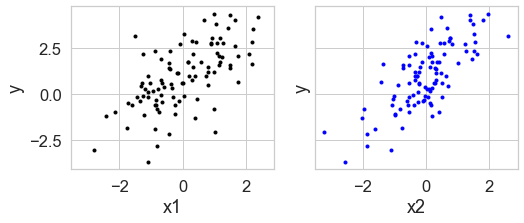

In [5]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(8,3), sharex=True, sharey=True);

axgrid[0].plot(x1_N, y_N, 'k.'); axgrid[0].set_xlabel('x1'); axgrid[0].set_ylabel('y');
axgrid[1].plot(x2_N, y_N, 'b.'); axgrid[1].set_xlabel('x2'); axgrid[1].set_ylabel('y');

# Model specified in Stan

In [25]:
model_code = '''
data {
  int N;
  vector[N] y;
  matrix[N, 2] x;
}
parameters {
  real alpha;
  vector[2] beta;
  real<lower=0> sigma; // constrain sigma > 0
}
model {
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);  // implicitly applied to each dim of vector beta
  sigma ~ normal(0, 5);  // implicitly takes into account the constraint: sigma > 0
  
  y ~ normal(alpha + x * beta, sigma);
}
'''

In [26]:
# Create dictionary to specify concrete values
# for each parameter named in 'data' section of model

data_N10 = dict(N=10, y=y_N[:10], x=x_N2[:10])

In [27]:
data_N100 = dict(N=100, y=y_N[:100], x=x_N2[:100])

# Setup: Compile the model

In [28]:
# Compile the model
stan_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd23e429a6ad903017bf2aa22ad5c0ed NOW.


# Setup: Prepare for plotting results

In [29]:
def plot_traces(fit):
    fig, ax_grid = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True);
    for ax, var_name, dim in zip(
            ax_grid.flatten(), ['alpha', 'sigma', 'beta', 'beta'], [None, None, 0, 1]):
        var_samples_S = fit[var_name]
        true_val = true_params[var_name]

        if dim is not None:
            var_samples_S = var_samples_S[:, dim]
            true_val = true_val[dim]
            var_name = var_name + "[%d]" % dim

        S = var_samples_S.size
        ax.plot(var_samples_S, 'b.', markersize=4, alpha=0.3, label='samples')
        ax.plot(true_val * np.ones(S), 'r-', label='true_value')
        ax.set_ylabel(var_name)

    ax.legend(bbox_to_anchor=(1.1, 1.0))
    ax.set_ylim([0, 2.0]);

# Run MAP estimator for N=10 dataset

In [30]:
map_N10 = stan_model.optimizing(
    data=data_N10,
    algorithm='LBFGS',
    init='0',
    verbose=True,
    iter=1000, seed=101)

In [31]:
for key, arr in map_N10.items():
    print(key, arr)

alpha 1.069345552413762
beta [1.0037347  1.44519989]
sigma 0.2008288334108678


In [13]:
for key, arr in true_params.items():
    print(key, arr)

alpha 1.0
beta [1.    1.337]
sigma 0.3


# Run MAP estimator for N=100 dataset

In [22]:
map_N100 = stan_model.optimizing(
    data=data_N100,
    algorithm='LBFGS',
    init='0',
    verbose=True,
    iter=1000, seed=101)

In [24]:
for key, arr in map_N100.items():
    print(key, arr)

alpha 0.9720035910601215
beta [0.98456774 1.34380053]
sigma 0.2901078085149014


# Run MCMC sampler for N=10 dataset

In [16]:
fit_N10 = stan_model.sampling(
    data=data_N10,
    algorithm='NUTS',
    init='0',
    verbose=True,
    iter=1000, chains=1, warmup=500, thin=1, seed=101)

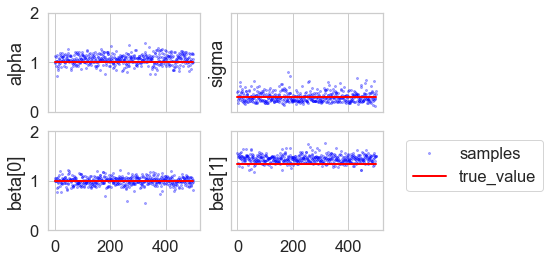

In [17]:
plot_traces(fit_N10)

# Run MCMC sampler for N=100 dataset

In [18]:
fit_N100 = stan_model.sampling(
    data=data_N100,
    algorithm='NUTS',
    init='0',
    verbose=True,
    iter=1000, chains=1, warmup=500, thin=1, seed=101)

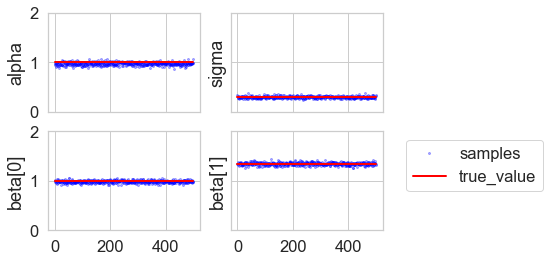

In [19]:
plot_traces(fit_N100)